## This code tests how well ANN detects anomalies in simulated timeseries

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

#import seaborn as sns
#from graphviz import Source

import simulated_data# df =  simulated_data.get_simulated_data()
df =  simulated_data.get_simulated_fixed_data()
df.head()

Using TensorFlow backend.


affected: [1] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [1] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [1, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [1] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [1] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [1, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### parameters to set

In [2]:
# fix random seed for reproducibility
# np.random.seed(17)

n_series = 6
# start_date = '2017-08-01 00:00:00'
# end_date = '2017-08-07 23:59:59'

# # regular behaviour
# max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# # anomalies
# p_anomaly = 2 * 10E-6
# max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
refh = 12
subh = 1
chance = refh/(subh+refh)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

epochs=60

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate  data

In [3]:
df =  simulated_data.get_simulated_fixed_data()
df.head()

affected: [1] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [1] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [1, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [1] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [1] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [1, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### plot timeseries

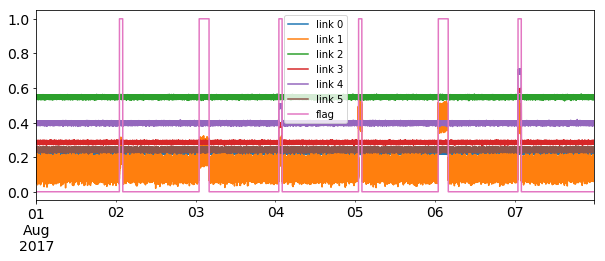

In [4]:
df.plot(figsize=(10,3.5))

#### create NN

In [5]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series*2, activation='relu'))    
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid') )# 

#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [6]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

In [7]:
df['score']=0.5

#find min and max timestamps
start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


0


InternalError: Blas GEMM launch failed : a.shape=(256, 6), b.shape=(6, 12), m=256, n=12, k=6
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_dense_1_input_0_0/_13, dense_1/kernel/read)]]
	 [[Node: loss/mul/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_606_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dense_1/MatMul', defined at:
  File "/usr/lib64/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib64/python3.4/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib64/python3.4/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/lib64/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib64/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib64/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3.4/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-4c072c260e1b>", line 22, in <module>
    score = check_for_anomaly(ref_df, sub_df, count)
  File "<ipython-input-6-089238bda0ed>", line 32, in check_for_anomaly
    m=getModel()
  File "<ipython-input-5-f4ec940040e8>", line 3, in getModel
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
  File "/usr/lib64/python3.4/site-packages/keras/models.py", line 442, in add
    layer(x)
  File "/usr/lib64/python3.4/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/lib64/python3.4/site-packages/keras/layers/core.py", line 841, in call
    output = K.dot(inputs, self.kernel)
  File "/usr/lib64/python3.4/site-packages/keras/backend/tensorflow_backend.py", line 998, in dot
    out = tf.matmul(x, y)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/ops/math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(256, 6), b.shape=(6, 12), m=256, n=12, k=6
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_dense_1_input_0_0/_13, dense_1/kernel/read)]]
	 [[Node: loss/mul/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_606_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
df.plot(figsize=(20,7))


In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()